In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import piecewise_regression
import statsmodels.api as sm

dms_df = pd.read_csv("output/mutations/data.csv")
len(dms_df)

4400

In [2]:
query_str="(single_nt == True) & (WT == False)"
data = dms_df.query(query_str).dropna()
len(data)

1214

Here's the piecewise regression setup we had before:

In [3]:
def do_piecewise_regression(measured_var, n_breakpoints):
    delta_thing = data[f"delta_{measured_var}"].to_numpy()
    enrichment = data["mutation enrichment"].to_numpy()

    if n_breakpoints is None:
        ms = piecewise_regression.ModelSelection(delta_thing, enrichment, max_breakpoints=5)
        return ms
    #else:
    pw_fit = piecewise_regression.Fit(delta_thing, enrichment, n_breakpoints=n_breakpoints)

    pw_fit.plot_data(color="grey", alpha=0.5)
    pw_fit.plot_fit(color="red", linewidth=4)
    pw_fit.plot_breakpoints()
    pw_fit.plot_breakpoint_confidence_intervals()
    pw_fit.summary()
    plt.xlabel("$\Delta$ affinity")
    plt.ylabel("mutation enrichment")
    plt.show()
    plt.close()
    return pw_fit

And we do the same PW regression as before, with the same result. Note that we get `p=7.93105e-08` for the existence of at least one breakpoint.


                    Breakpoint Regression Results                     
No. Observations                     1214
No. Model Parameters                    4
Degrees of Freedom                   1210
Res. Sum of Squares               292.615
Total Sum of Squares              403.105
R Squared                        0.274098
Adjusted R Squared               0.271696
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const               -1.03333       0.0741      -13.947      4.17e-41      -1.1787     -0.88796
alpha1            -0.0931372       0.0551      -1.6917         0.091     -0.20115     0.014876
beta1                1.24953        0.095       13.153             -       1.0631       1.4359
breakpoint1        -0.539252       0.0533            -             -     -0.64378     -0.43472
-----------------

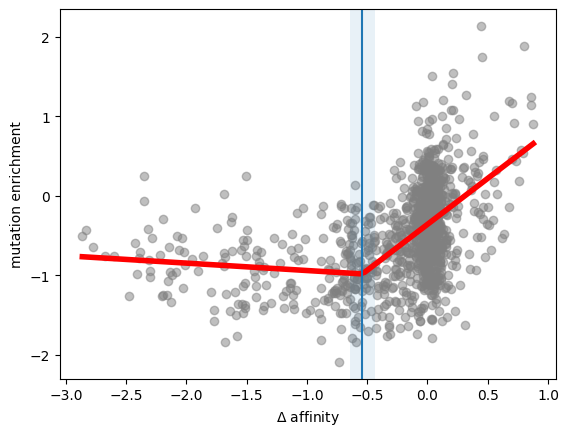

In [4]:
pw_fit = do_piecewise_regression("bind_CGG", 1)

OK, let's look at the residual of delta affinity now. No signal, as expected given than we are plotting the residual:

<Axes: xlabel='delta_bind_CGG', ylabel='enrichment affinity residual'>

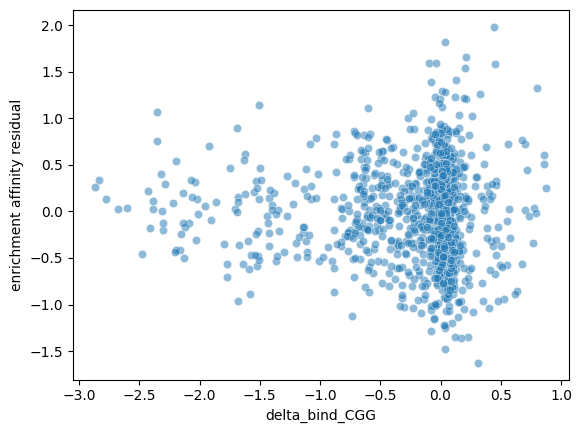

In [5]:
predicted_values = pw_fit.predict(data['delta_bind_CGG'].values)
data['enrichment affinity residual'] = data['mutation enrichment'] - predicted_values

# Plot the residuals 
sns.scatterplot(data=data, x='delta_bind_CGG', y='enrichment affinity residual', alpha=0.5)

Now let's look at the influence of the residual.

Text(0, 0.5, 'enrichment affinity residual')

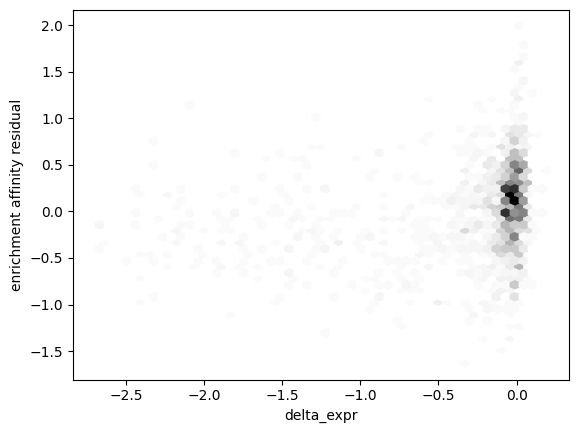

In [6]:
plt.figure()
plt.hexbin(data['delta_expr'], data['enrichment affinity residual'], gridsize=50, cmap='Greys')
plt.xlabel('delta_expr')
plt.ylabel('enrichment affinity residual')

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0603      0.016      3.851      0.000       0.030       0.091
delta_expr     0.1951      0.024      8.028      0.000       0.147       0.243


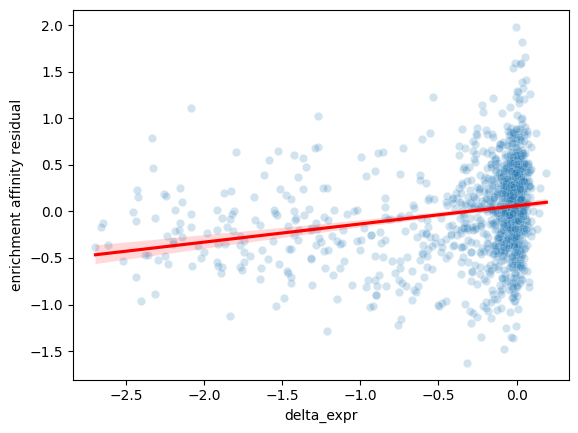

In [7]:
def linear_regression(data, predictor, response):
   """
   Perform linear regression analysis with plots and statistics.
   
   Args:
       data: pandas DataFrame
       predictor: str, column name for independent variable
       response: str, column name for dependent variable
   """
   # Plot
   sns.scatterplot(data=data, x=predictor, y=response, alpha=0.2)
   sns.regplot(data=data, x=predictor, y=response, scatter=False, color='red')
   
   # Regression analysis
   X = data[predictor]
   X = sm.add_constant(X)
   model = sm.OLS(data[response], X).fit()
   print(model.summary().tables[1])


linear_regression(data, 'delta_expr', 'enrichment affinity residual')

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3072      0.017    -18.590      0.000      -0.340      -0.275
delta_expr     0.4919      0.026     19.183      0.000       0.442       0.542


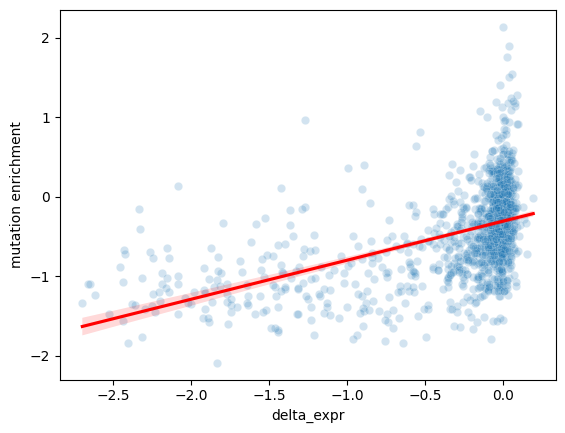

In [8]:
linear_regression(data, 'delta_expr', 'mutation enrichment')

In [13]:
# TODO move this up to some module

from statsmodels.nonparametric.smoothers_lowess import lowess

def regplot_lowess_ci(data, x, y, ci_level, n_boot, ax=None, scatter_kwargs={}, line_kwargs={}):
    """
    Create a LOWESS regression plot with confidence intervals.

    Args:
        data (pd.DataFrame): DataFrame containing the data.
        x (str): Column name for the x-axis variable.
        y (str): Column name for the y-axis variable.
        ci_level (float): Confidence interval level (e.g., 95 for 95% CI).
        n_boot (int): Number of bootstrap samples for confidence interval estimation.
        ax (matplotlib.axes._axes.Axes, optional): Axes to plot on. If None, a new figure and axes will be created.
        scatter_kwargs (dict, optional): Additional keyword arguments for the scatter plot.
        line_kwargs (dict, optional): Additional keyword arguments for the line plot.
    
    Returns:
        matplotlib.axes._axes.Axes: The axes with the plot.
    """
    x_ = data[x].to_numpy()
    y_ = data[y].to_numpy()
    x_grid = np.linspace(start=x_.min(), stop=x_.max(), num=1000)

    def reg_func(_x, _y):
        return lowess(exog=_x, endog=_y, xvals=x_grid)

    beta_boots = sns.algorithms.bootstrap(
        x_, y_,
        func=reg_func,
        n_boot=n_boot,
    )
    err_bands = sns.utils.ci(beta_boots, ci_level, axis=0)
    y_plt = reg_func(x_, y_)

    # If no axis is provided, create one
    if ax is None:
        _, ax = plt.subplots()

    sns.scatterplot(x=x_, y=y_, ax=ax, **scatter_kwargs)
    sns.lineplot(x=x_grid, y=y_plt, ax=ax, **line_kwargs)
    ax.fill_between(x_grid, *err_bands, alpha=0.15, **line_kwargs)

    return ax

In [17]:
query_str = "(single_nt == True) & (WT == False)"
# Slope is ML estimator for Poisson regression using an identity link function.
# Here we set this up for the complete dataset but also use the same formula for the per-timepoint data below.
slope = dms_df.query(query_str)["mutation abundance"].sum() / dms_df.query(query_str)["mutation rate"].sum()
rate_grid = np.geomspace(1e-4, dms_df.query(query_str)["mutation rate"].max(), 100)
predicted_events = slope * dms_df.query(query_str)["mutation rate"]
dms_df["mutation enrichment"] = np.log10((.5 + dms_df.query(query_str)["mutation abundance"]) / (.5 + predicted_events))
dms_df["delta_avidity"] = dms_df["delta_bind_CGG"] + dms_df["delta_expr"]

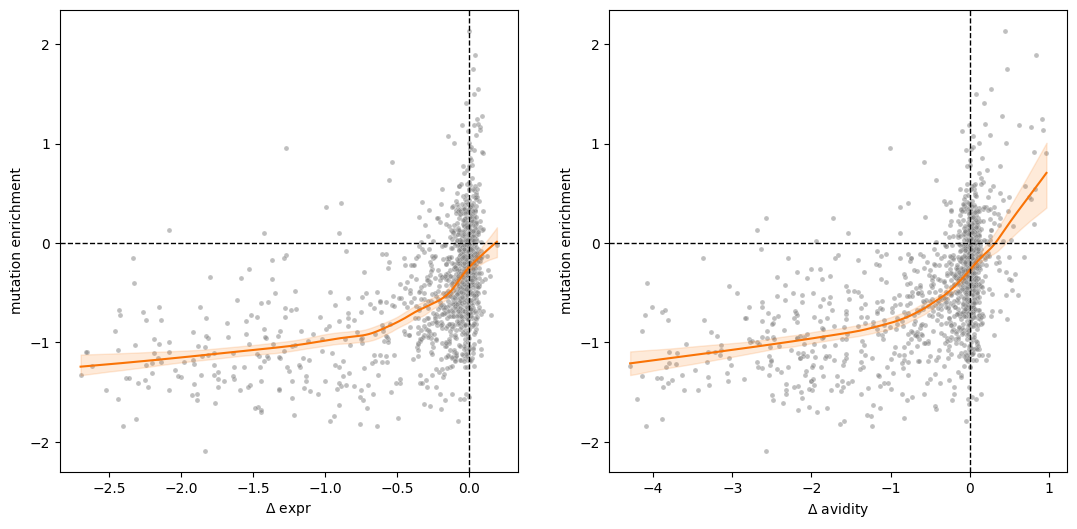

In [19]:
def plot_enrichment_vs_delta(measured_var, ax):
    regplot_lowess_ci(data=dms_df.query(query_str).dropna(),
            x=f"delta_{measured_var}", y="mutation enrichment",
            ci_level=95, n_boot=100,
            scatter_kwargs=dict(s=13, alpha=0.5, color="grey"),
            line_kwargs=dict(color="xkcd:orange"),
            ax=ax,
            )
    ax.axhline(0, color="k", linestyle="--", linewidth=1)
    ax.axvline(0, color="k", linestyle="--", linewidth=1)
    ax.set_xlabel(fr"$\Delta$ {measured_var}")
    ax.set_ylabel("mutation enrichment")

fig, axs = plt.subplots(1, 2, figsize=(13, 6))
plot_enrichment_vs_delta("expr", axs[0])
plot_enrichment_vs_delta("avidity", axs[1])